# Poisson regression exercise

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os as os
from scipy.special import factorial

'/content'

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/bird_count.csv')
df

,count,yr,observerAge,lineCov
0,2,2011,63,1.000000
1,5,2010,64,0.987500
2,12,2002,30,0.991667
3,12,2006,60,0.987500
4,5,2008,62,0.987500
5,12,2012,64,1.000000
6,5,2000,28,0.991667
7,8,2005,59,0.987500
8,9,2007,61,0.987500
9,14,2004,58,1.000000


In [ ]:
class PoissonModel():
  def __init__(self,x,y):
    self.n , self.p = np.shape(x)
    self.beta = np.zeros(self.p)
    self.x = x
    self.y = y
    pass

  def set_beta(self,beta):
    self.beta = beta
    xbeta = self.x@self.beta
    self.xbeta = xbeta
    self.lmbd = np.exp(xbeta)


  def poisson_loglik(self):
    logy_fact = np.log(factorial(self.y))
    loglik = np.sum(-self.lmbd + self.y*self.xbeta - logy_fact)
    self.loglik = loglik
    return loglik

  def grad_loglik(self):
    grad_loglik = np.zeros(self.p)
    for k in range(self.p):
      x_k = self.x[:,k]
      grad_loglik[k] = np.sum(-x_k * self.lmbd) + np.sum(x_k * self.y)
    self.F = grad_loglik
    return self.F

  def grad_loglik2(self):
    grad_loglik = np.zeros(self.p)
    eps = 1e-5
    beta_init = self.beta
    loglik_init = self.poisson_loglik()
    for k in range(self.p):
      beta = np.copy(beta_init)
      beta[k] += eps
      self.set_beta(beta)
      loglik_fd = self.poisson_loglik()
      grad_loglik[k] = (loglik_fd - loglik_init) / eps
      self.set_beta(beta_init)
    self.F = grad_loglik
    return grad_loglik


  def jac(self):
    F_prime = np.zeros((self.p,self.p))
    F_prime2 = np.zeros((self.p,self.p))
    for l in range(self.p):
      for k in range(self.p):
        x_k = self.x[:,k]
        x_l = self.x[:,l]
        F_prime[l,k] = np.sum(-x_k*x_l*self.lmbd)
    self.F_prime = F_prime
    return F_prime



  def newton_iter(self):
    F_prime = self.jac()
    F = self.grad_loglik()
    delta = np.linalg.solve(F_prime,F)
    newbeta = self.beta - delta
    self.set_beta(newbeta)
    return newbeta , delta

  def fit(self):
    for i in range(50):
      beta , delta = self.newton_iter()
      if(np.linalg.norm(delta)<1e-8):
        print('Convergence attained')
        print(f'Beta: {self.beta}')
        return self.beta
    print('Newtons method may not have converged')
    return self.beta

  def predict(self,x_predict):
    lmbda_pred = np.exp(self.beta@x_predict)
    generated_obs = np.random.poisson(lmbda_pred,1)[0]
    return lmbda_pred, generated_obs








In [ ]:
a = np.ones((2,3))
beta = [1,2,3]
y = [4,5]

test = PoissonModel(a,y)
test.set_beta(beta)
print(test.poisson_loglik())
test.grad_loglik()



-760.8231325586003


array([-797.85758699, -797.85758699, -797.85758699])

Convergence attained
Beta: [0.77702866]
[2.175]


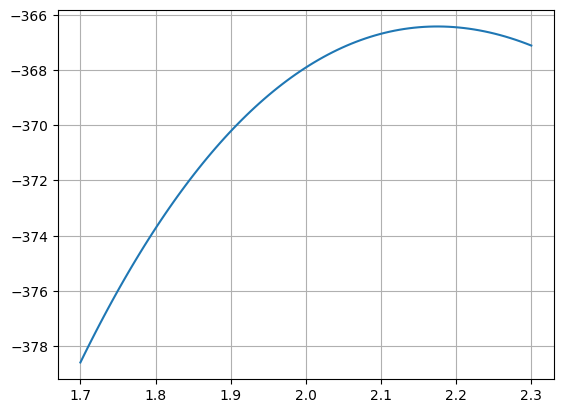

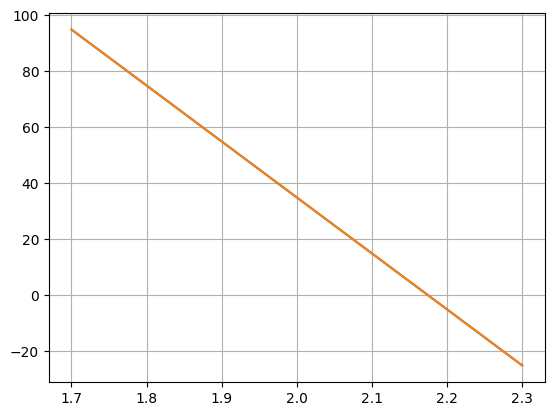

In [ ]:
n = 200
x = np.ones((n,1))
beta = np.array([np.log(1)])
x@beta

y = np.random.poisson(2,n)

test=PoissonModel(x,y)
test.set_beta(beta)
test.fit()
print(np.exp(test.beta))

beta_list = np.linspace(np.log(1.7),np.log(2.3),100)
loglik_list = np.zeros_like(beta_list)
grad_list = np.zeros_like(beta_list)
grad_list2 = np.zeros_like(beta_list)
gradgrad_listfd = np.zeros_like(beta_list)
for i , beta in enumerate(beta_list):
  test.set_beta(np.array([beta]))
  loglik_list[i] = test.poisson_loglik()
  grad_list[i] = test.grad_loglik()[0]
  grad_list2[i] = test.grad_loglik2()[0]
  gradgrad_list[i] = test.jac()[0,0]

gradgrad_listfd = (gradgrad_list[1:] - gradgrad_list[:-1]) / (beta_list[1]-beta_list[0])


plt.plot(np.exp(beta_list),loglik_list)
plt.grid()

plt.figure()
plt.plot(np.exp(beta_list),grad_list)
plt.plot(np.exp(beta_list),grad_list2)
plt.grid()



## Fitting to the birds

In [ ]:
df['Ones'] = 1
x = df[['Ones','yr']].to_numpy()
y = df['count'].to_numpy()

bird_model = PoissonModel(x,y)
bird_model.set_beta(np.array([0,0]))
bird_model.fit()

year = 2010
lmbda_hat , generated_obs = bird_model.predict(np.array([1,year]))

print(f'Inferred value of lambda for the year {year}: {lmbda_hat}')
print(f'Generated observation: {generated_obs}')

Convergence attained
Beta: [ 6.71792057e+01 -3.24431585e-02]
Inferred value of lambda for the year 2010: 7.159621198169713
Generated observation: 8
